In [ ]:
!pip install torch torchvision

# important library:

In [ ]:
# Standard library imports
import os  # For handling file paths
import random  # For generating random numbers
from collections import Counter  # For counting hashable objects

# Third-party imports
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
from PIL import Image, ImageDraw  # For image handling and drawing
import matplotlib.pyplot as plt  # For plotting
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets

# PyTorch imports
import torch  # For tensor operations and neural networks
import torchvision  # For computer vision tasks

# Torchvision imports
from torchvision import transforms as T  # For data transformations
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor  # For Faster R-CNN model


# load train data:

In [ ]:
train = pd.read_csv("/kaggle/input/global-wheat-detection/train.csv")
train.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

- split the bbox column to x1,y1,w,h

In [ ]:
coord = pd.DataFrame(list(train.bbox.apply(lambda x : x[1:-1].split(",")).values),columns=["x1","y1","w","h"])

In [ ]:
df = pd.concat([train,coord],axis=1)

- make the values of the columns numeric values:

In [ ]:
df

image_id  width  height                         bbox     source  \
0       b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]    usask_1   
1       b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]    usask_1   
2       b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]    usask_1   
3       b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]    usask_1   
4       b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]    usask_1   
...           ...    ...     ...                          ...        ...   
147788  5e0747034   1024    1024    [64.0, 619.0, 84.0, 95.0]  arvalis_2   
147789  5e0747034   1024    1024  [292.0, 549.0, 107.0, 82.0]  arvalis_2   
147790  5e0747034   1024    1024  [134.0, 228.0, 141.0, 71.0]  arvalis_2   
147791  5e0747034   1024    1024   [430.0, 13.0, 184.0, 79.0]  arvalis_2   
147792  5e0747034   1024    1024   [875.0, 740.0, 94.0, 61.0]  arvalis_2   

           x1      y1       w       h  
0       834.0   222.0    56.0    36.0  
1       226.0   548.0   130.0    58.0  
2       377.0   504.0    74.0   160.0  
3       834.0    95.0   109.0   107.0  
4        26.0   144.0   124.0   117.0  
...       ...     ...     ...     ...  
147788   64.0   619.0    84.0    95.0  
147789  292.0   549.0   107.0    82.0  
147790  134.0   228.0   141.0    71.0  
147791  430.0    13.0   184.0    79.0  
147792  875.0   740.0    94.0    61.0  

[147793 rows x 9 columns]

In [ ]:
df['x1']=pd.to_numeric(df['x1'])
df['y1']=pd.to_numeric(df['y1'])
df['w']=pd.to_numeric(df['w'])
df['h']=pd.to_numeric(df['h'])

- calcualte the y2,x2 :

In [ ]:
df['x2']=df['x1']+df['w']
df['y2']=df['y1']+df['h']

In [ ]:
df

image_id  width  height                         bbox     source  \
0       b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]    usask_1   
1       b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]    usask_1   
2       b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]    usask_1   
3       b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]    usask_1   
4       b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]    usask_1   
...           ...    ...     ...                          ...        ...   
147788  5e0747034   1024    1024    [64.0, 619.0, 84.0, 95.0]  arvalis_2   
147789  5e0747034   1024    1024  [292.0, 549.0, 107.0, 82.0]  arvalis_2   
147790  5e0747034   1024    1024  [134.0, 228.0, 141.0, 71.0]  arvalis_2   
147791  5e0747034   1024    1024   [430.0, 13.0, 184.0, 79.0]  arvalis_2   
147792  5e0747034   1024    1024   [875.0, 740.0, 94.0, 61.0]  arvalis_2   

           x1     y1      w      h     x2     y2  
0       834.0  222.0   56.0   36.0  890.0  258.0  
1       226.0  548.0  130.0   58.0  356.0  606.0  
2       377.0  504.0   74.0  160.0  451.0  664.0  
3       834.0   95.0  109.0  107.0  943.0  202.0  
4        26.0  144.0  124.0  117.0  150.0  261.0  
...       ...    ...    ...    ...    ...    ...  
147788   64.0  619.0   84.0   95.0  148.0  714.0  
147789  292.0  549.0  107.0   82.0  399.0  631.0  
147790  134.0  228.0  141.0   71.0  275.0  299.0  
147791  430.0   13.0  184.0   79.0  614.0   92.0  
147792  875.0  740.0   94.0   61.0  969.0  801.0  

[147793 rows x 11 columns]

- Drop unneeded column:

In [ ]:
df.drop(['bbox','width','height','w','h','source'],axis=1,inplace=True)

In [ ]:
df.head()

image_id     x1     y1     x2     y2
0  b6ab77fd7  834.0  222.0  890.0  258.0
1  b6ab77fd7  226.0  548.0  356.0  606.0
2  b6ab77fd7  377.0  504.0  451.0  664.0
3  b6ab77fd7  834.0   95.0  943.0  202.0
4  b6ab77fd7   26.0  144.0  150.0  261.0

- Take the unique ids of the images:

In [ ]:
unique_imgs=df.image_id.unique()
unique_imgs

array(['b6ab77fd7', 'b53afdf5c', '7b72ea0fb', ..., 'a5c8d5f5c',
       'e6b5e296d', '5e0747034'], dtype=object)

- Make custom class for preparing the data:

In [ ]:
/kaggle/input/global-wheat-detection/train/

In [ ]:
# Define a custom dataset class inheriting from torch.utils.data.Dataset
class custDat(torch.utils.data.Dataset):
    def __init__(self, df, unique_imgs, indices):
        """
        Initialize the dataset with a DataFrame, a list of unique image names, and indices.

        Args:
            df (pd.DataFrame): DataFrame containing image IDs and bounding box information.
            unique_imgs (list): List of unique image names.
            indices (list): List of indices to be used for accessing the dataset.
        """
        self.df = df  # DataFrame containing image and bounding box data
        self.unique_imgs = unique_imgs  # List of unique image names
        self.indices = indices  # Indices for accessing the images in the dataset

    def __len__(self):
        """
        Return the length of the dataset.

        Returns:
            int: Number of samples in the dataset.
        """
        return len(self.indices)  # Length of the dataset based on the indices

    def __getitem__(self, idx):
        """
        Get an item from the dataset at the specified index.

        Args:
            idx (int): Index of the item to be fetched.

        Returns:
            tuple: Tuple containing the image tensor and the target dictionary.
        """
        # Get the image name using the index
        image_name = self.unique_imgs[self.indices[idx]]

        # Get the bounding boxes for the image
        boxes = self.df[self.df.image_id == image_name].values[:, 1:].astype("float")

        # Open the image and convert it to RGB format
        img = Image.open("../input/global-wheat-detection/train/" + image_name + ".jpg").convert('RGB')

        # Create labels tensor with value 1 for each bounding box
        labels = torch.ones(boxes.shape[0], dtype=torch.int64)

        # Create the target dictionary containing boxes and labels
        target = {}
        target["boxes"] = torch.tensor(boxes)  # Bounding boxes as a tensor
        target["label"] = labels  # Labels as a tensor

        # Return the image converted to a tensor and the target dictionary
        return T.ToTensor()(img), target


# spit the data int train and validation:

In [ ]:
train_inds , val_inds =train_test_split(range(unique_imgs.shape[0]),test_size=0.1)

In [ ]:
def custom_collate(data):
    return data

Need for custom_collate in Object Detection
Handling Variable Number of Annotations:

In object detection, each image can have a different number of objects, and consequently, a different number of annotations (bounding boxes). The default collate function in PyTorch (default_collate) expects each sample in the batch to have the same shape, which is not the case here.
Maintaining Data Structure:

The custom_collate function helps maintain the structure of the data when it is batched together. Specifically, it returns the data as a list of tuples, where each tuple contains an image tensor and its corresponding target dictionary. This structure is essential for the Faster R-CNN model, which expects a list of such tuples as input.
Avoiding Collate Errors:

Without a custom collate function, the DataLoader might try to convert the list of dictionaries (targets) into a single tensor, which would fail due to the variable number of bounding boxes per image.

Input: data is a list of tuples. Each tuple contains:

An image tensor (e.g., T.ToTensor()(img)).
A target dictionary (e.g., target with keys "boxes" and "labels").
Output: The same list of tuples is returned without any modification.

# Call the data loader to prepare it to the model:

In [ ]:
train_dl = torch.utils.data.DataLoader(custDat(df,unique_imgs,train_inds),
                                       batch_size=16,
                                       shuffle=True,
                                       collate_fn=custom_collate,
                                       pin_memory=True if torch.cuda.is_available() else False)
val_dl = torch.utils.data.DataLoader(custDat(df,unique_imgs,val_inds),
                                     batch_size=8,
                                     shuffle=True,
                                     collate_fn=custom_collate,
                                     pin_memory=True if torch.cuda.is_available() else False)

# Modeling:

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 165MB/s] 


In [ ]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
num_classes=2

In [ ]:
in_features=model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor =  FastRCNNPredictor(in_features,num_classes)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9,weight_decay=0.005)
num_epochs=5

_ train the model with 5 epochs and prin the loss:

In [ ]:
# Move the model to the specified device (CPU or GPU)
model.to(device)

# Loop over the number of epochs
for epoch in range(num_epochs):
    epoch_loss = 0  # Initialize the loss for the current epoch

    # Loop over the data in the training DataLoader
    for data in train_dl:
        imgs = []  # List to store the images
        targets = []  # List to store the target dictionaries

        # Loop over each data sample in the batch
        for d in data:
            # Append the image tensor to the imgs list and move it to the device
            imgs.append(d[0].to(device))

            # Create a target dictionary for the current sample
            targ = {}
            # Move the bounding boxes tensor to the device
            targ['boxes'] = d[1]['boxes'].to(device)
            # Move the labels tensor to the device
            targ['labels'] = d[1]['label'].to(device)

            # Append the target dictionary to the targets list
            targets.append(targ)

        # Perform a forward pass through the model and get the loss dictionary
        loss_dict = model(imgs, targets)

        # Sum all the losses in the loss dictionary to get the total loss
        loss = sum(v for v in loss_dict.values())

        # Add the loss for the current batch to the epoch loss, converting it to a numpy value
        epoch_loss += loss.cpu().detach().numpy()

        # Zero the gradients of the optimizer
        optimizer.zero_grad()

        # Backpropagate the loss
        loss.backward()

        # Update the model parameters
        optimizer.step()

    # Print the total loss for the current epoch
    print(epoch_loss)

212.87230346874833
168.3196318354067
156.1594448418628


- Evaluate the model

In [ ]:
model.eval()
data = iter(val_dl).__next__()

In [ ]:
img= data[0][0]
boxes=data[0][1]['boxes']
labels=data[0][1]['label']

In [ ]:
output = model([img.to(device)])

- output os the evaluation:

In [ ]:
output

[{'boxes': tensor([[7.5366e+02, 1.4106e+02, 8.7587e+02, 1.9808e+02],
          [1.3857e+00, 4.0630e+02, 9.1559e+01, 5.1023e+02],
          [6.4054e+02, 1.4772e+02, 7.3151e+02, 2.4629e+02],
          [9.1608e+02, 7.2930e+02, 1.0210e+03, 7.9889e+02],
          [9.7039e+02, 3.3454e+02, 1.0240e+03, 4.2903e+02],
          [6.5780e+02, 9.5133e-01, 7.1769e+02, 6.9991e+01],
          [3.0831e+02, 6.6519e+02, 3.8696e+02, 7.3656e+02],
          [9.6181e+02, 4.5292e+02, 1.0240e+03, 4.9846e+02],
          [4.3536e+02, 8.3494e+02, 5.8670e+02, 9.1897e+02],
          [6.1255e+02, 3.3493e+02, 7.5997e+02, 3.9698e+02],
          [2.3550e+02, 9.6899e+02, 3.2135e+02, 1.0240e+03],
          [1.7863e+02, 6.3894e+02, 2.6363e+02, 6.8859e+02],
          [7.8291e+02, 6.0451e+02, 8.2924e+02, 7.0852e+02],
          [5.6188e+02, 2.4089e+02, 6.9385e+02, 3.2589e+02],
          [2.2869e+02, 2.1374e+00, 3.3744e+02, 5.7387e+01],
          [5.2289e+01, 1.0534e+02, 1.6072e+02, 1.5594e+02],
          [7.7806e+02, 2.7181e+

In [ ]:
out_bbox=output[0]['boxes']
out_scores=output[0]['scores']

In [ ]:
keep = torchvision.ops.nms(out_bbox,out_scores,0.45)

In [ ]:
out_bbox.shape , keep.shape

(torch.Size([94, 4]), torch.Size([91]))

- prediction detection:

In [ ]:
im = (img.permute(1,2,0).cpu().detach().numpy()*255).astype('uint8')
im

array([[[ 70,  86,  39],
        [ 71,  87,  40],
        [ 70,  87,  42],
        ...,
        [ 73,  94,  63],
        [ 73,  93,  65],
        [ 73,  93,  65]],

       [[ 69,  85,  40],
        [ 71,  87,  42],
        [ 72,  88,  43],
        ...,
        [ 74,  94,  66],
        [ 73,  93,  65],
        [ 73,  93,  65]],

       [[ 67,  80,  37],
        [ 69,  84,  41],
        [ 73,  88,  45],
        ...,
        [ 68,  86,  60],
        [ 67,  85,  59],
        [ 67,  85,  59]],

       ...,

       [[ 93, 108,  65],
        [ 93, 108,  65],
        [ 94, 109,  68],
        ...,
        [ 33,  35,  30],
        [ 33,  33,  31],
        [ 33,  33,  31]],

       [[110, 126,  81],
        [105, 120,  77],
        [100, 115,  74],
        ...,
        [ 30,  30,  28],
        [ 29,  29,  29],
        [ 29,  29,  29]],

       [[124, 140,  95],
        [116, 132,  87],
        [106, 121,  80],
        ...,
        [ 26,  26,  24],
        [ 27,  27,  27],
        [ 28,  28,  28]]

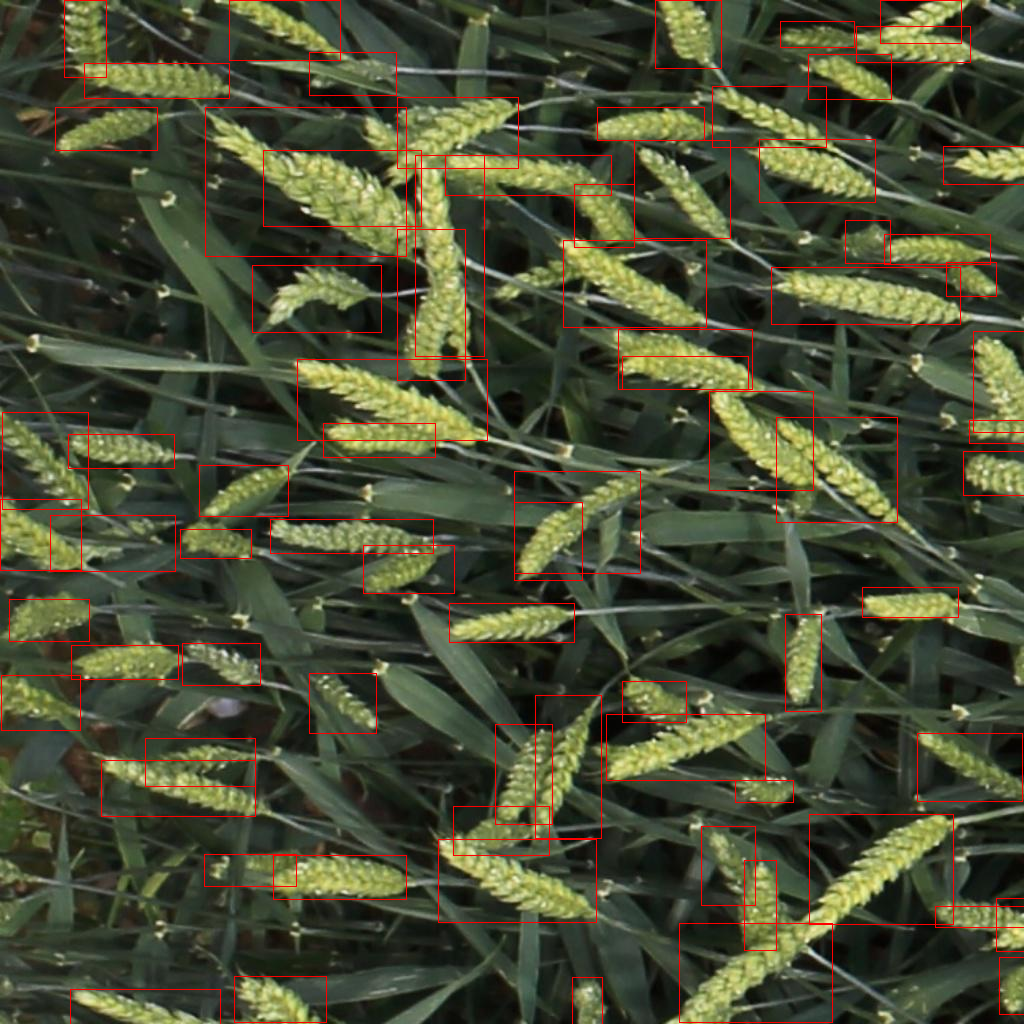

In [ ]:
vsample = Image.fromarray(im)
draw = ImageDraw.Draw(vsample)
for box in boxes :
    draw.rectangle(list(box),fill=None,outline='red')
vsample

In [ ]:
# Save the model state
torch.save(model.state_dict(), 'modified_fasterrcnn_resnet50_fpn.pth')

In [ ]:
model.eval()
data = iter(val_dl).__next__()

img= data[0][0]
boxes=data[0][1]['boxes']
labels=data[0][1]['label']

output = model([img.to(device)])

out_bbox=output[0]['boxes']
out_scores=output[0]['scores']

keep = torchvision.ops.nms(out_bbox,out_scores,0.45)

out_bbox.shape , keep.shape
im = (img.permute(1,2,0).cpu().detach().numpy()*255).astype('uint8')

vsample = Image.fromarray(im)
draw = ImageDraw.Draw(vsample)
for box in boxes :
    draw.rectangle(list(box),fill=None,outline='red')
vsample

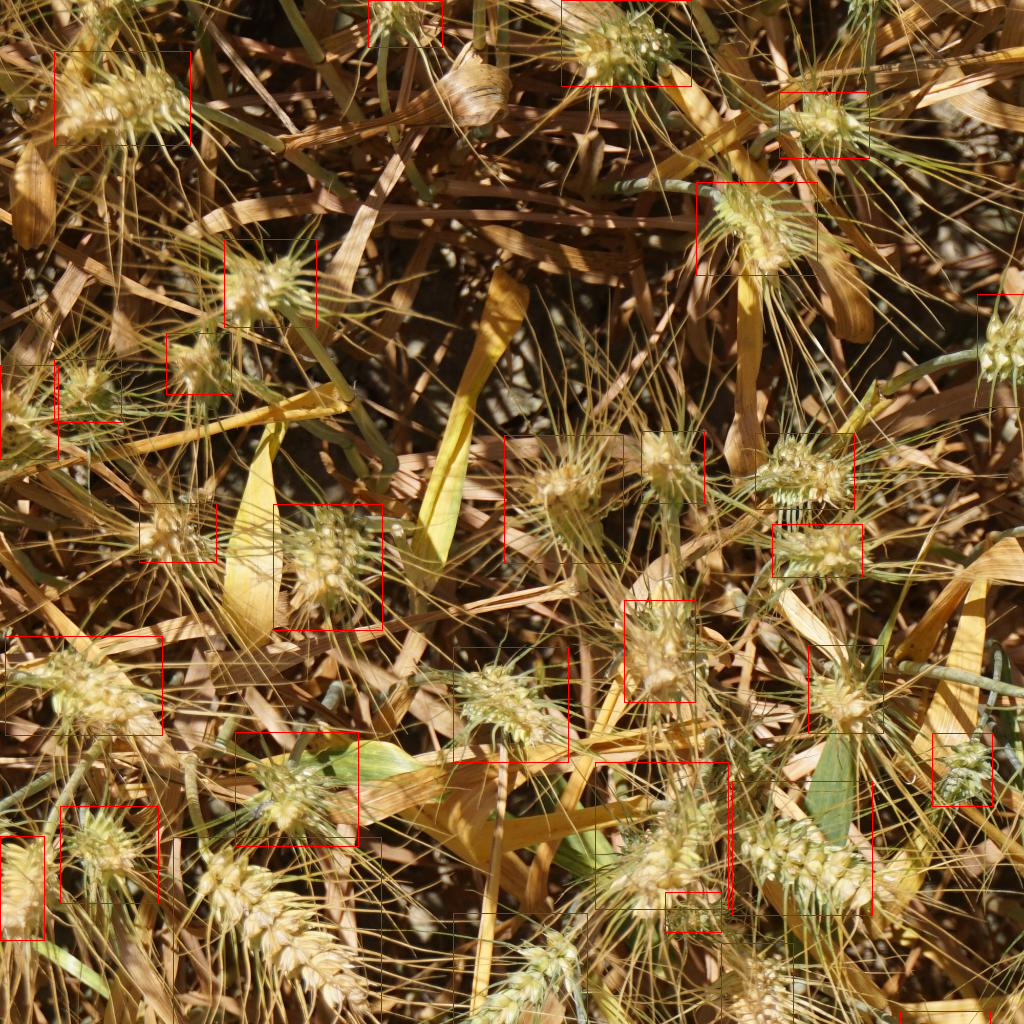

In [ ]:
model.eval()
data = iter(val_dl).__next__()

img= data[0][0]
boxes=data[0][1]['boxes']
labels=data[0][1]['label']

output = model([img.to(device)])

out_bbox=output[0]['boxes']
out_scores=output[0]['scores']

keep = torchvision.ops.nms(out_bbox,out_scores,0.45)

out_bbox.shape , keep.shape
im = (img.permute(1,2,0).cpu().detach().numpy()*255).astype('uint8')

vsample = Image.fromarray(im)
draw = ImageDraw.Draw(vsample)
for box in boxes :
    draw.rectangle(list(box),fill=None,outline='red')
vsample

# Load the saved model

In [ ]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Function to create the model and replace the classifier head
def create_model(num_classes):
    # Load a pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=False)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one (adjusting for the number of classes)
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Specify the number of classes (1 class + background)
num_classes = 2

# Create a model instance
model2 = create_model(num_classes)

# Load the saved model state dictionary
model2.load_state_dict(torch.load('/kaggle/working/modified_fasterrcnn_resnet50_fpn.pth'))

# Move the model to the specified device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model2.to(device)

# Now the model is ready to be used for inference or further training

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

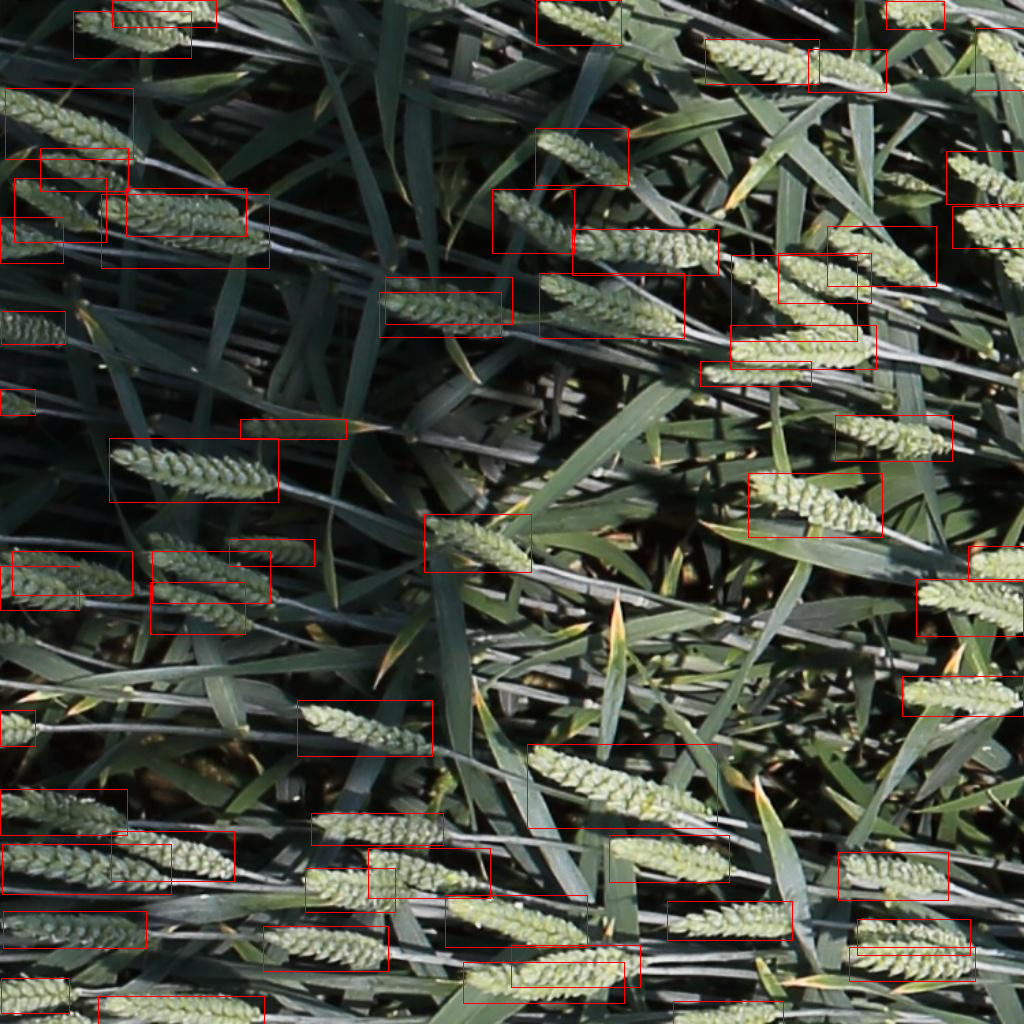

In [ ]:
model2.eval()
data = iter(val_dl).__next__()

img= data[0][0]
boxes=data[0][1]['boxes']
labels=data[0][1]['label']

output = model([img.to(device)])

out_bbox=output[0]['boxes']
out_scores=output[0]['scores']

keep = torchvision.ops.nms(out_bbox,out_scores,0.45)

out_bbox.shape , keep.shape
im = (img.permute(1,2,0).cpu().detach().numpy()*255).astype('uint8')

vsample = Image.fromarray(im)
draw = ImageDraw.Draw(vsample)
for box in boxes :
    draw.rectangle(list(box),fill=None,outline='red')
vsample